In [27]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine
import torchinfo

In [28]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [29]:
data_path = Path("data/")
image_path = data_path / "soil_low_med_high"

In [30]:
# Get a set of pretrained model weights
weights = torchvision.models.AlexNet_Weights.DEFAULT
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [31]:
#HyperParameters
batch_Size = 5
learning_rate = 0.001
epochS = 10
dropout_prob = 0.2

In [32]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [33]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x18c65c043b0>,
 ['high', 'low', 'medium'])

In [34]:
model = torchvision.models.alexnet(weights=weights).to(device)

In [35]:
# # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.parameters():
    param.requires_grad = False

In [36]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=9216, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [37]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

 10%|█         | 1/10 [00:21<03:09, 21.01s/it]

Epoch: 1 | train_loss: 1.1783 | train_acc: 0.4294 | test_loss: 1.0363 | test_acc: 0.6800


 20%|██        | 2/10 [00:42<02:49, 21.16s/it]

Epoch: 2 | train_loss: 0.2611 | train_acc: 0.9059 | test_loss: 0.4958 | test_acc: 0.6800


 30%|███       | 3/10 [01:02<02:24, 20.60s/it]

Epoch: 3 | train_loss: 0.1077 | train_acc: 0.9882 | test_loss: 0.5882 | test_acc: 0.8000


 40%|████      | 4/10 [01:21<02:01, 20.25s/it]

Epoch: 4 | train_loss: 0.0564 | train_acc: 1.0000 | test_loss: 0.5193 | test_acc: 0.8000


 50%|█████     | 5/10 [01:43<01:43, 20.70s/it]

Epoch: 5 | train_loss: 0.0386 | train_acc: 1.0000 | test_loss: 0.5262 | test_acc: 0.7600


 60%|██████    | 6/10 [02:04<01:22, 20.67s/it]

Epoch: 6 | train_loss: 0.0282 | train_acc: 1.0000 | test_loss: 0.4700 | test_acc: 0.7600


 70%|███████   | 7/10 [02:22<00:59, 19.91s/it]

Epoch: 7 | train_loss: 0.0206 | train_acc: 1.0000 | test_loss: 0.5076 | test_acc: 0.8000


 80%|████████  | 8/10 [02:42<00:40, 20.12s/it]

Epoch: 8 | train_loss: 0.0176 | train_acc: 1.0000 | test_loss: 0.5240 | test_acc: 0.8000


 90%|█████████ | 9/10 [03:04<00:20, 20.45s/it]

Epoch: 9 | train_loss: 0.0142 | train_acc: 1.0000 | test_loss: 0.5110 | test_acc: 0.8000


100%|██████████| 10/10 [03:23<00:00, 20.33s/it]

Epoch: 10 | train_loss: 0.0125 | train_acc: 1.0000 | test_loss: 0.4993 | test_acc: 0.8000
[INFO] Total training time: 203.295 seconds


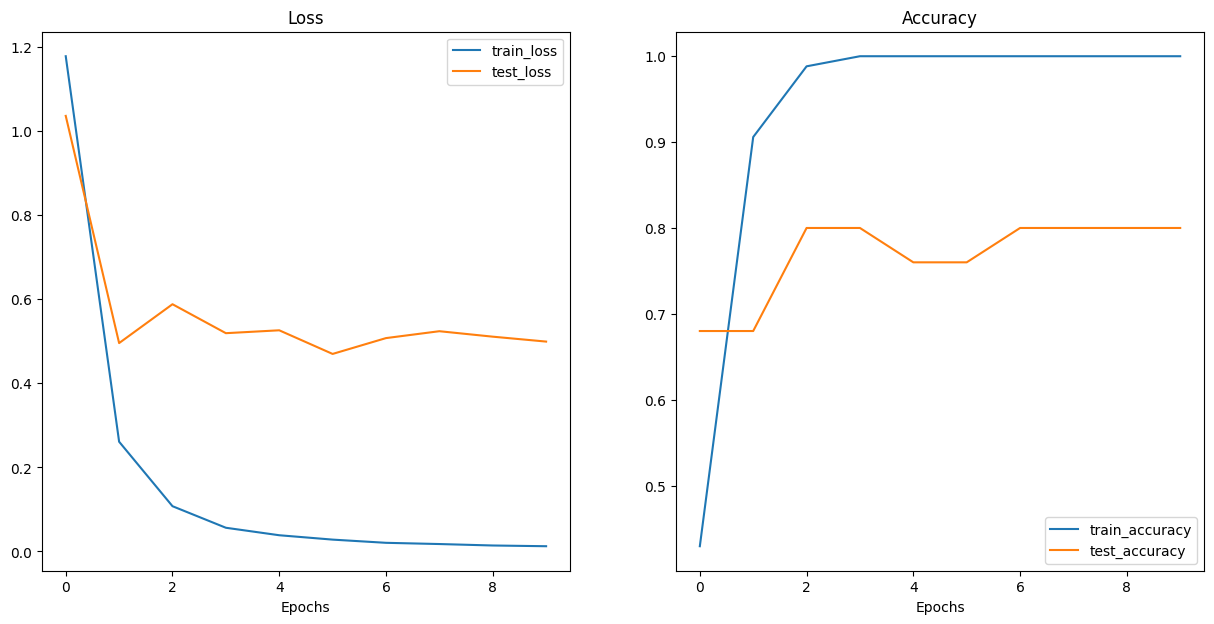

In [39]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)